# Lista 3
#### Marcos da Silva Barreto (msb5)

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import copy
import statistics

from deslib.des.knora_e import KNORAE
from deslib.des.knora_u import KNORAU
from deslib.dcs.ola import OLA
from deslib.dcs.lca import LCA
from deslib.dcs.mcb import MCB
from deslib.static.static_selection import StaticSelection

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_score, recall_score

from imblearn.over_sampling import SMOTE

## Databases

- As bases contem 22 atributos, 21 relacionadas à predição de defeito de software, e 1 indicando a classe da instância.
- Nenhum atributo contem valores nulos.
- Distribução por classe:

Database | # of instances (False class) | # of instances (True class) | Total of instances
------ | ------ | ------ | ------
CM1 | **449** *(90.16%)* | **49** *(9.83%)* | **498**
KC1 | **1783** *(84.54%)* | **326** *(15.45%)* | **2109**

### CM1

In [2]:
cm1_data = pd.read_csv("./databases/cm1.txt", header=None)
cm1_n_row, cm1_n_column = cm1_data.shape
cm1_columns = ["X{}".format(i) for i in range(0, cm1_n_column-1)] + ["y"]
cm1_data.columns = cm1_columns
cm1_data["y"] = cm1_data["y"].apply(lambda x: 1 if x == True else 0)
cm1_columns = cm1_columns[-1:] + cm1_columns[:-1]
cm1_data = cm1_data[cm1_columns]
cm1_data.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
0,0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,...,1.30,2,2,2,2,1.2,1.2,1.2,1.2,1.4
1,1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,...,1.00,1,1,1,1,1.0,1.0,1.0,1.0,1.0
2,0,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,...,163.15,1,0,6,0,15.0,15.0,44.0,19.0,9.0
3,0,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,...,191.55,0,0,3,0,16.0,8.0,31.0,16.0,7.0
4,0,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,...,333.31,0,0,3,0,16.0,12.0,46.0,26.0,11.0


### KC1

In [3]:
kc1_data = pd.read_csv("./databases/kc1.txt", header=None)
kc1_n_row, kc1_n_column = kc1_data.shape
kc1_columns = ["X{}".format(i) for i in range(0, kc1_n_column-1)] + ["y"]
kc1_data.columns = kc1_columns
kc1_data["y"] = kc1_data["y"].apply(lambda x: 1 if x == True else 0)
kc1_columns = kc1_columns[-1:] + kc1_columns[:-1]
kc1_data = kc1_data[kc1_columns]
kc1_data.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
0,0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,...,1.30,2,2,2,2,1.2,1.2,1.2,1.2,1.4
1,1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,...,1.00,1,1,1,1,1.0,1.0,1.0,1.0,1.0
2,1,83.0,11.0,1.0,11.0,171.0,927.89,0.04,23.04,40.27,...,1187.70,65,10,6,0,18.0,25.0,107.0,64.0,21.0
3,1,46.0,8.0,6.0,8.0,141.0,769.78,0.07,14.86,51.81,...,635.37,37,2,5,0,16.0,28.0,89.0,52.0,15.0
4,1,25.0,3.0,1.0,3.0,58.0,254.75,0.11,9.35,27.25,...,132.33,21,0,2,0,11.0,10.0,41.0,17.0,5.0


## Experimentos

### kDN
Método para calcular o _kDN hardness_ das instâncias de X (https://arxiv.org/pdf/1804.07419.pdf)
- k igual a 5 (utilizado no cálculo da vizinhança);
- limiar kDN igual a 0.5 (limiar de separação entre instâncias "fáceis" [<= 0.5] e "difíceis" [> 0.5])

In [4]:
def kdn(X, y, k=5, threshold=.5):    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    
    neighbors = knn.kneighbors(X, return_distance=False)
    
    hard = []
    zz = list(zip(y.index, neighbors))
    for i, instance_neighbors in zip(y.index, neighbors):
        kdn_value = (y.iloc[instance_neighbors] != y[i]).values.sum() / k
        hard.append(kdn_value > threshold)
    
    hard = np.array(hard)
    return X[~hard], y[~hard], X[hard], y[hard]

### Métricas
Método para o cálculo das métricas utilizadas no exercício:
- Métricas: Acurácia, AUC, Medida F (f-measure) e Média Geométrica (g-mean);
- Parâmetros: classes preditas e as classes verdadeiras;
- Métricas auxiliares: Precisão e Cobertura.

In [96]:
def get_metrics(y_pred, y_true):
    def g_mean(true, pred):
        conf_matrix = confusion_matrix(true, pred)
        tp = conf_matrix[1][1]
        tn = conf_matrix[0][0]
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]

        tp_rate = tp / (tp + fn)
        tn_rate = tn / (tn + fp)
        precision = tp / (tp + fp)

        return math.sqrt(tp_rate * tn_rate), math.sqrt(tp_rate * precision)
    
    def get_auc(true, pred):
        fpr, tpr, _ = roc_curve(true, pred)
        return auc(fpr, tpr)
    
    acc = accuracy_score(y_true, y_pred)
    auc_score = get_auc(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    g_mean_score, g_mean_score2 = g_mean(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    return {
        "accuracy": acc,
        "auc": auc_score,
        "f_measure": f_measure,
        "g_mean": g_mean_score,
        "precision": precision,
        "recall": recall
    }

### Execução e avaliação dos métodos de seleção
- Geração do _pool_ inicial de classificadores com _Bagging_ de tamanho igual a 100;
- Inicialização dos métodos de seleção:
    - Seleção Dinâmica de Classificadores: _LCA_, _MCB_ e _OLA_;
    - Seleção Dinâmica de Ensembles: _KNORA-E_ e _KNORA-U_;
    - Seleção Estática: _Static Selection_.
- Balanceamento das classes utilizando a técnica _SMOTE_;
- Normalização dos dados com _StandardScaler_: média e o desvio padrão por atributo no conjunto de dados;
- Inicialização do _k-fold cross validation_ com _StratifiedKFold_ para igual distribuição de instâncias por classe em cada fold;
    - Divisão do subconjunto de treinamento para geração do subconjunto de validação de forma aleatória e estratificada;
        - 70% treinamento;
        - 20% validação;
        - 10% teste.
    - Geração das configurações do experimento com a aplicação da técnica _kDN hardness_: três subconjuntos de validação (original, "fácil" e "difícil");
    - Treinamento do _pool_ inicial de classificadores com o subconjunto de treinamento;
    - Treinamento dos métodos de seleção com os subconjuntos de validação;
    - Avaliação dos métodos de seleção com o subconjunto de teste, utilizando o conjunto de métricas.

In [97]:
def evaluate(X, y, n_pool = 100, k_fold = 10, random_state=42):
    perceptron = CalibratedClassifierCV(Perceptron(random_state=random_state))
    pool_classifiers = BaggingClassifier(perceptron, n_estimators=n_pool, n_jobs=-1, verbose=0, random_state=random_state)
    
    mcb = MCB(random_state=random_state)
    ola = OLA(random_state=random_state)
    lca = LCA(random_state=random_state)
    kne = KNORAE(random_state=random_state)
    knu = KNORAU(random_state=random_state)
    static = StaticSelection(random_state=random_state)
    
    print('Original data: # of samples', len(X), '# of samples of class 0:', len(X[y==0]), '# of samples of class 1:', len(X[y==1]))
    smote = SMOTE(random_state=42, n_jobs=-1)
    X, y = smote.fit_resample(X, y)
    print('SMOTEd data: # of samples', len(X), '# of samples of class 0:', len(X[y==0]), '# of samples of class 1:', len(X[y==1]))

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(data=X)

    # Creating stratified k-folds
    cv = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=random_state)

    scores = []
    index = 0
    for train_index, test_index in cv.split(X, list(y.values)):
        print("Running #{} fold".format(index))
        epoch = {"execution": index}

        # Separating train and test datasets
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

        # Separating training dataset into train and validation datasets. In the end will be 70/20/10 to train/validation/test
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.23, random_state=random_state, stratify=y_train)
        X_val_easy, y_val_easy, X_val_hard, y_val_hard = kdn(X_val, y_val)
        print('# of instances in Easy Validation dataset:', len(X_val_easy), '# of instances in Hard Validation dataset:', len(X_val_hard))

        # Training the original pool of classifiers using ONLY training dataset (validation dataset excluded)
        pool_classifiers.fit(X_train, y_train.values)

        # Set DCS and DES algorithms' pool of classifiers
        mcb.pool_classifiers = pool_classifiers
        ola.pool_classifiers = pool_classifiers
        lca.pool_classifiers = pool_classifiers
        kne.pool_classifiers = pool_classifiers
        knu.pool_classifiers = pool_classifiers
        static.pool_classifiers = pool_classifiers

        # Using original validation dataset (without any filtering of instance hardness)
        mcb.fit(X_val, y_val.values)
        ola.fit(X_val, y_val.values)
        lca.fit(X_val, y_val.values)
        kne.fit(X_val, y_val.values)
        knu.fit(X_val, y_val.values)
        static.fit(X_val, y_val.values)

        mcb_standard = mcb.predict(X_test)
        ola_standard = ola.predict(X_test)
        lca_standard = lca.predict(X_test)
        kne_standard = kne.predict(X_test)
        knu_standard = knu.predict(X_test)
        static_standard = static.predict(X_test)

        epoch["mcb_standard"] = get_metrics(mcb_standard, y_test.values)
        epoch["ola_standard"] = get_metrics(ola_standard, y_test.values)
        epoch["lca_standard"] = get_metrics(lca_standard, y_test.values)
        epoch["kne_standard"] = get_metrics(kne_standard, y_test.values)
        epoch["knu_standard"] = get_metrics(knu_standard, y_test.values)
        epoch["static_standard"] = get_metrics(static_standard, y_test.values)

        # Using easy instances (kDN <= 0.5) in validation dataset
        mcb.fit(X_val_easy, y_val_easy.values)
        ola.fit(X_val_easy, y_val_easy.values)
        lca.fit(X_val_easy, y_val_easy.values)
        kne.fit(X_val_easy, y_val_easy.values)
        knu.fit(X_val_easy, y_val_easy.values)
        static.fit(X_val_easy, y_val_easy.values)

        mcb_easy = mcb.predict(X_test)
        ola_easy = ola.predict(X_test)
        lca_easy = lca.predict(X_test)
        kne_easy = kne.predict(X_test)
        knu_easy = knu.predict(X_test)
        static_easy = static.predict(X_test)

        epoch["mcb_easy"] = get_metrics(mcb_easy, y_test.values)
        epoch["ola_easy"] = get_metrics(ola_easy, y_test.values)
        epoch["lca_easy"] = get_metrics(lca_easy, y_test.values)
        epoch["kne_easy"] = get_metrics(kne_easy, y_test.values)
        epoch["knu_easy"] = get_metrics(knu_easy, y_test.values)
        epoch["static_easy"] = get_metrics(static_easy, y_test.values)

        # Using hard instances (kDN > 0.5) in validation dataset
        mcb.fit(X_val_hard, y_val_hard.values)
        ola.fit(X_val_hard, y_val_hard.values)
        lca.fit(X_val_hard, y_val_hard.values)
        kne.fit(X_val_hard, y_val_hard.values)
        knu.fit(X_val_hard, y_val_hard.values)
        static.fit(X_val_hard, y_val_hard.values)

        mcb_hard = mcb.predict(X_test)
        ola_hard = ola.predict(X_test)
        lca_hard = lca.predict(X_test)
        kne_hard = kne.predict(X_test)
        knu_hard = knu.predict(X_test)
        static_hard = static.predict(X_test)

        epoch["mcb_hard"] = get_metrics(mcb_hard, y_test.values)
        epoch["ola_hard"] = get_metrics(ola_hard, y_test.values)
        epoch["lca_hard"] = get_metrics(lca_hard, y_test.values)
        epoch["kne_hard"] = get_metrics(kne_hard, y_test.values)
        epoch["knu_hard"] = get_metrics(knu_hard, y_test.values)
        epoch["static_hard"] = get_metrics(static_hard, y_test.values)
        
        scores.append(epoch)
        index = index + 1
    return scores

### Separação dos atributos e classe da base CM1

In [98]:
X = cm1_data.iloc[:,1:]
y = cm1_data.iloc[:,0]

### Geração dos resultados para a base CM1
- Distribuição das classes antes e depois da técnica _SMOTE_;
- Tamanho dos novos subconjuntos de validação: _Easy_ e _Hard_, a cada _fold_.

In [99]:
results = evaluate(X, y)

Original data: # of samples 498 # of samples of class 0: 449 # of samples of class 1: 49
SMOTEd data: # of samples 898 # of samples of class 0: 449 # of samples of class 1: 449
Running #0 fold
# of instances in Easy Validation dataset: 150 # of instances in Hard Validation dataset: 36
Running #1 fold
# of instances in Easy Validation dataset: 155 # of instances in Hard Validation dataset: 31
Running #2 fold
# of instances in Easy Validation dataset: 160 # of instances in Hard Validation dataset: 26
Running #3 fold
# of instances in Easy Validation dataset: 156 # of instances in Hard Validation dataset: 30
Running #4 fold
# of instances in Easy Validation dataset: 156 # of instances in Hard Validation dataset: 30
Running #5 fold
# of instances in Easy Validation dataset: 153 # of instances in Hard Validation dataset: 33
Running #6 fold
# of instances in Easy Validation dataset: 157 # of instances in Hard Validation dataset: 29
Running #7 fold
# of instances in Easy Validation dataset: 1

### Salvando os resultados

In [100]:
json.dump(results, open('./results/cm1/cm1_results.json', 'w'), indent=4, sort_keys=True)

### Separação dos atributos e classe da base KC1

In [101]:
X = kc1_data.iloc[:,1:]
y = kc1_data.iloc[:,0]

### Geração dos resultados para a base KC1
- Distribuição das classes antes e depois da técnica _SMOTE_;
- Tamanho dos novos subconjuntos de validação: _Easy_ e _Hard_, a cada _fold_.

In [102]:
results = evaluate(X, y)

Original data: # of samples 2109 # of samples of class 0: 1783 # of samples of class 1: 326
SMOTEd data: # of samples 3566 # of samples of class 0: 1783 # of samples of class 1: 1783
Running #0 fold
# of instances in Easy Validation dataset: 613 # of instances in Hard Validation dataset: 126
Running #1 fold
# of instances in Easy Validation dataset: 608 # of instances in Hard Validation dataset: 131
Running #2 fold
# of instances in Easy Validation dataset: 624 # of instances in Hard Validation dataset: 115
Running #3 fold
# of instances in Easy Validation dataset: 613 # of instances in Hard Validation dataset: 126
Running #4 fold
# of instances in Easy Validation dataset: 619 # of instances in Hard Validation dataset: 120
Running #5 fold
# of instances in Easy Validation dataset: 618 # of instances in Hard Validation dataset: 121
Running #6 fold
# of instances in Easy Validation dataset: 618 # of instances in Hard Validation dataset: 121
Running #7 fold
# of instances in Easy Validati

### Salvando os resultados

In [103]:
json.dump(results, open('./results/kc1/kc1_results.json', 'w'), indent=4, sort_keys=True)

Bases de dados após a aplicação da técnica SMOTE para balanceamento de classes:

Database | # of instances (False class) | # of instances (True class) | Total of instances
------ | ------ | ------ | ------
CM1 | **449** *(50%)* | **449** *(50%)* | **2109**
KC1 | **1783** *(50%)* | **1783** *(50%)* | **3566**

## Analisando os resultados

#### Configurações de estilo do Matplotlib

In [13]:
plt.style.use('./presentation.mplstyle')

### Configurações dos experimentos

In [ ]:
algorithms = ['lca', 'kne', 'knu', 'mcb', 'ola', 'static']
val_set = ['standard', 'easy', 'hard']
metrics = ['accuracy', 'auc', 'f_measure', 'g_mean', 'precision', 'recall']

### Formatação dos resultados
- Construção de um _Dataframe_ geral com todos os resultados
- Construção de um dicionário separando os resultados por algoritmo (método de seleção)

In [104]:
def parse_results(results):
    df = {}
    per_alg = {}
    for algorithm in algorithms:
        per_alg[algorithm] = {}
        for vs in val_set:
            for metric in metrics:
                per_alg_config = '{}_{}'.format(vs, metric)
                config_ = '{}_{}'.format(algorithm, vs)
                config = '{}_{}_{}'.format(algorithm, vs, metric)
                df[config] = []
                per_alg[algorithm][per_alg_config] = []
                for execution in results:
                    if config in df and config_ in execution:
                        df[config].append(execution[config_][metric])
                    elif config in df:
                        del df[config]
                        
                    if per_alg_config in per_alg[algorithm] and config_ in execution:
                        per_alg[algorithm][per_alg_config].append(execution[config_][metric])
                    elif per_alg_config in per_alg:
                        del per_alg[algorithm][per_alg_config]
    
    for algorithm in algorithms:
        for vs in val_set:
            for metric in metrics:
                per_alg_config = '{}_{}'.format(vs, metric)
                per_alg[algorithm][per_alg_config] = {'mean': statistics.mean(per_alg[algorithm][per_alg_config]), 'std': statistics.stdev(per_alg[algorithm][per_alg_config])}

    return pd.DataFrame.from_dict(df), per_alg

### Formatação dos resultados v2
- Construção de um dicionários no seguinte formato:
    - Métrica -> Algoritmo -> Configuração do subconjunto de validação -> (média, desvio padrão)

In [105]:
def parse_results2(results):
    df = {}
    for metric in metrics:
        df[metric] = {}
        for algorithm in algorithms:
            df[metric][algorithm] = {}
            for vs in val_set:    
                df[metric][algorithm][vs] = []
                alg_vs = '{}_{}'.format(algorithm, vs)
                for execution in results:
                    if alg_vs in execution and metric in execution[alg_vs]:
                        df[metric][algorithm][vs].append(execution[alg_vs][metric])
                if df[metric][algorithm][vs] == []:
                    del df[metric][algorithm][vs]
                    
    for metric in metrics:
        for algorithm in algorithms:
            for vs in val_set:
                df[metric][algorithm][vs] = {'mean': statistics.mean(df[metric][algorithm][vs]), 'std': statistics.stdev(df[metric][algorithm][vs])}

    return df

### Formatação dos resultados v3
- Construção de um dicionários no seguinte formato:
    - Métrica -> Configuração do subconjunto de validação -> Algoritmo -> (média, desvio padrão)

In [ ]:
def parse_results3(results):
    df = {}
    for metric in metrics:
        df[metric] = {}
        for vs in val_set:
            df[metric][vs] = {}
            for algorithm in algorithms:
                df[metric][vs][algorithm] = []
                alg_vs = '{}_{}'.format(algorithm, vs)
                for execution in results:
                    if alg_vs in execution and metric in execution[alg_vs]:
                        df[metric][vs][algorithm].append(execution[alg_vs][metric])
                if df[metric][vs][algorithm] == []:
                    del df[metric][vs][algorithm]
                    
    for metric in metrics:        
        for vs in val_set:
            for algorithm in algorithms:
                df[metric][vs][algorithm] = {'mean': statistics.mean(df[metric][vs][algorithm]), 'std': statistics.stdev(df[metric][vs][algorithm])}

    return df

#### Separação de média e desvio padrão em dois dicionários

In [106]:
def separate_mean_std(mean_std):
    def get_by_attr(data, attr):
        new_data = copy.deepcopy(data)
        for alg, vs in new_data.items():
            for name, results in vs.items():
                new_data[alg][name] = results[attr]
        return new_data

    return get_by_attr(mean_std, 'mean'), get_by_attr(mean_std, 'std')

### Geração do gráfico por métrica
- Gráfico de barras (média) com erros (desvio padrão)

In [107]:
def plot_mean_std(mean, std, title, ylabel, columns, indexes):    
    df_mean = pd.DataFrame.from_dict(mean)
    df_std = pd.DataFrame.from_dict(std)
    
    df_mean.columns = columns
    df_std.columns = columns
    
    df_mean.index=indexes
    df_std.index=indexes
    
    display(df_mean)
    
    df_mean.plot.bar(xlabel='Validation set', title=title, ylabel=ylabel, yerr=df_std, figsize=(8,6), rot=0, grid=True, width=.9)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(columns))
    plt.show()

def plot_by_metric(metric_results, title, ylabel, columns=['LCA', 'KNORA-E', 'KNORA-U', 'MCB', 'OLA', 'Static Selection'], indexes=['Standard', 'Easy', 'Hard']):
    mean, std = separate_mean_std(metric_results)
    plot_mean_std(mean, std, title, ylabel, columns, indexes)

#### Carregando os resultados da base CM1

In [108]:
cm1_results = json.load(open('./results/cm1/cm1_results.json', 'r'))

#### Utilizando os três formatadores de resultados

In [109]:
cm1_results_df, cm1_results_alg = parse_results(cm1_results)
cm1_results_metric = parse_results2(cm1_results)
cm1_results_metric2 = parse_results3(cm1_results)

#### _Dataframe_ com os resultados gerais, para todos os _folds_

In [20]:
cm1_results_df

,lca_standard_accuracy,lca_standard_auc,lca_standard_f_measure,lca_standard_g_mean,lca_easy_accuracy,lca_easy_auc,lca_easy_f_measure,lca_easy_g_mean,lca_hard_accuracy,lca_hard_auc,...,static_standard_f_measure,static_standard_g_mean,static_easy_accuracy,static_easy_auc,static_easy_f_measure,static_easy_g_mean,static_hard_accuracy,static_hard_auc,static_hard_f_measure,static_hard_g_mean
0,0.722222,0.722222,0.731183,0.755556,0.711111,0.711111,0.711111,0.711111,0.755556,0.755556,...,0.790698,0.755556,0.788889,0.788889,0.781609,0.755556,0.800000,0.800000,0.790698,0.755556
1,0.833333,0.833333,0.838710,0.866667,0.855556,0.855556,0.865979,0.933333,0.744444,0.744444,...,0.881720,0.911111,0.877778,0.877778,0.881720,0.911111,0.844444,0.844444,0.844444,0.844444
2,0.722222,0.722222,0.719101,0.711111,0.800000,0.800000,0.812500,0.866667,0.733333,0.733333,...,0.735632,0.711111,0.744444,0.744444,0.735632,0.711111,0.744444,0.744444,0.716049,0.644444
3,0.722222,0.722222,0.691358,0.622222,0.744444,0.744444,0.722892,0.666667,0.655556,0.655556,...,0.756098,0.688889,0.766667,0.766667,0.746988,0.688889,0.777778,0.777778,0.750000,0.666667
4,0.711111,0.711111,0.682927,0.622222,0.733333,0.733333,0.733333,0.733333,0.633333,0.633333,...,0.813953,0.777778,0.822222,0.822222,0.818182,0.800000,0.811111,0.811111,0.795181,0.733333
5,0.722222,0.722222,0.766355,0.911111,0.722222,0.722222,0.752475,0.844444,0.666667,0.666667,...,0.690476,0.644444,0.711111,0.711111,0.690476,0.644444,0.700000,0.700000,0.674699,0.622222
6,0.733333,0.733333,0.739130,0.755556,0.700000,0.700000,0.696629,0.688889,0.733333,0.733333,...,0.777778,0.777778,0.777778,0.777778,0.777778,0.777778,0.800000,0.800000,0.795455,0.777778
7,0.733333,0.733333,0.700000,0.622222,0.722222,0.722222,0.683544,0.600000,0.622222,0.622222,...,0.756098,0.688889,0.777778,0.777778,0.756098,0.688889,0.755556,0.755556,0.725000,0.644444
8,0.797753,0.798232,0.804348,0.840909,0.797753,0.798990,0.816327,0.909091,0.730337,0.729545,...,0.800000,0.772727,0.797753,0.797475,0.790698,0.772727,0.808989,0.808333,0.795181,0.750000
9,0.842697,0.842929,0.840909,0.822222,0.831461,0.831818,0.827586,0.800000,0.662921,0.666162,...,0.883721,0.844444,0.898876,0.899495,0.894118,0.844444,0.887640,0.888384,0.880952,0.822222


#### Resultados por algoritmo (método de seleção)

In [21]:
cm1_results_alg

{'lca': {'standard_accuracy': {'mean': 0.7540449438202247,
   'std': 0.05034121964804056},
  'standard_auc': {'mean': 0.7541161616161616, 'std': 0.050433176973012486},
  'standard_f_measure': {'mean': 0.7514020942639008,
   'std': 0.05887845719438036},
  'standard_g_mean': {'mean': 0.752979797979798, 'std': 0.10724591524091451},
  'easy_accuracy': {'mean': 0.7618102372034956, 'std': 0.05480017032815945},
  'easy_auc': {'mean': 0.761969696969697, 'std': 0.05494205175871518},
  'easy_f_measure': {'mean': 0.7622376894466967, 'std': 0.06331105094999454},
  'easy_g_mean': {'mean': 0.7753535353535354, 'std': 0.11179992591791094},
  'hard_accuracy': {'mean': 0.6937702871410736, 'std': 0.05030050702168003},
  'hard_auc': {'mean': 0.6940151515151515, 'std': 0.050026641260309784},
  'hard_f_measure': {'mean': 0.6529986893920089, 'std': 0.10780459220278768},
  'hard_g_mean': {'mean': 0.6125757575757576, 'std': 0.1788345494450958}},
 'kne': {'standard_accuracy': {'mean': 0.8486142322097379,
   'st

#### Resultados formatado em: Métrica -> Algortimo -> Configuração do subconjunto de validação

In [22]:
cm1_results_metric

{'accuracy': {'lca': {'standard': {'mean': 0.7540449438202247,
    'std': 0.05034121964804056},
   'easy': {'mean': 0.7618102372034956, 'std': 0.05480017032815945},
   'hard': {'mean': 0.6937702871410736, 'std': 0.05030050702168003}},
  'kne': {'standard': {'mean': 0.8486142322097379, 'std': 0.04583986027803526},
   'easy': {'mean': 0.8084893882646692, 'std': 0.043696728275201754},
   'hard': {'mean': 0.7372659176029963, 'std': 0.06898183118517061}},
  'knu': {'standard': {'mean': 0.8063420724094882, 'std': 0.05219285904261674},
   'easy': {'mean': 0.805230961298377, 'std': 0.05375196613474906},
   'hard': {'mean': 0.7974406991260924, 'std': 0.05384257689015366}},
  'mcb': {'standard': {'mean': 0.8185393258426966, 'std': 0.03967245803818398},
   'easy': {'mean': 0.7962546816479401, 'std': 0.044347705897200135},
   'hard': {'mean': 0.7071660424469414, 'std': 0.08671860087807752}},
  'ola': {'standard': {'mean': 0.8140948813982521, 'std': 0.04171355080419659},
   'easy': {'mean': 0.79963

## Gráficos comparando as configurações dos subconjuntos de validação

### CM1

#### Acurácia

,LCA,KNORA-E,KNORA-U,MCB,OLA,Static Selection
Standard,0.754045,0.848614,0.806342,0.818539,0.814095,0.798552
Easy,0.761810,0.808489,0.805231,0.796255,0.799638,0.796330
Hard,0.693770,0.737266,0.797441,0.707166,0.724969,0.792996


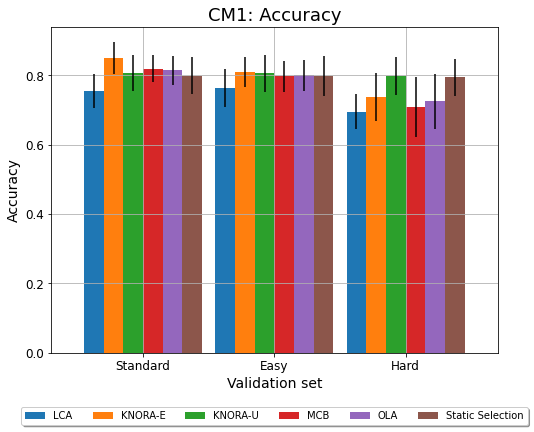

In [95]:
plot_by_metric(cm1_results_metric['accuracy'], 'CM1: Accuracy', 'Accuracy')

#### AUC

,LCA,KNORA-E,KNORA-U,MCB,OLA,Static Selection
Standard,0.754116,0.848712,0.806364,0.818662,0.814242,0.798561
Easy,0.761970,0.808460,0.805278,0.796263,0.799672,0.796364
Hard,0.694015,0.737475,0.797449,0.707449,0.725202,0.793005


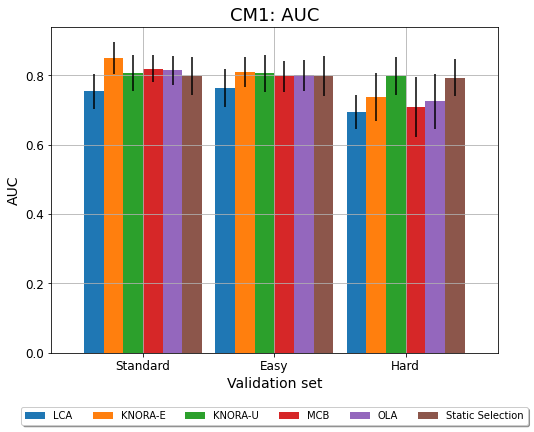

In [96]:
plot_by_metric(cm1_results_metric['auc'], 'CM1: AUC', 'AUC')

#### Medida F (f-measure)

,LCA,KNORA-E,KNORA-U,MCB,OLA,Static Selection
Standard,0.751402,0.849366,0.796099,0.821537,0.818291,0.788617
Easy,0.762238,0.810800,0.796043,0.799478,0.806181,0.787330
Hard,0.652999,0.695729,0.783620,0.658116,0.676572,0.776766


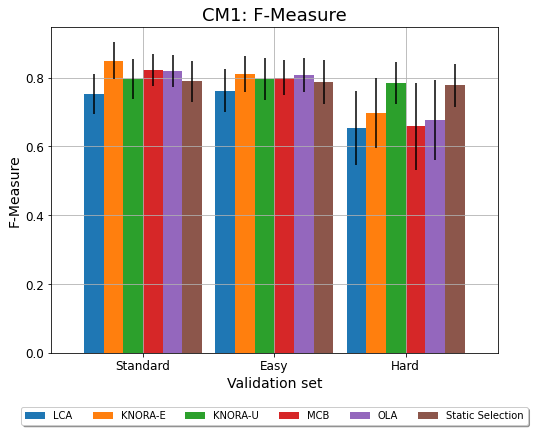

In [97]:
plot_by_metric(cm1_results_metric['f_measure'], 'CM1: F-Measure', 'F-Measure')

#### Média geométrica (g-mean)

,LCA,KNORA-E,KNORA-U,MCB,OLA,Static Selection
Standard,0.752980,0.866566,0.761717,0.844293,0.844293,0.757273
Easy,0.775354,0.833030,0.766212,0.821970,0.842020,0.759495
Hard,0.612576,0.624141,0.739444,0.590808,0.601869,0.726111


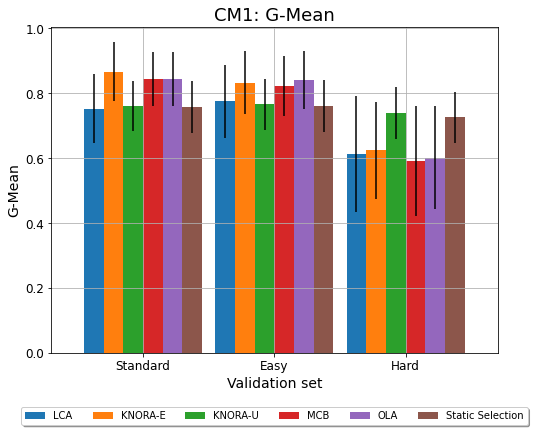

In [98]:
plot_by_metric(cm1_results_metric['g_mean'], 'CM1: G-Mean', 'G-Mean')

#### Carregando os resultados da base KC1

In [110]:
kc1_results = json.load(open('./results/kc1/kc1_results.json', 'r'))

#### Utilizando os três formatadores de resultados

In [111]:
kc1_results_df, kc1_results_alg = parse_results(kc1_results)
kc1_results_metric = parse_results2(kc1_results)
kc1_results_metric2 = parse_results3(kc1_results)

#### _Dataframe_ com os resultados gerais, para todos os _folds_

In [25]:
kc1_results_df

,lca_standard_accuracy,lca_standard_auc,lca_standard_f_measure,lca_standard_g_mean,lca_easy_accuracy,lca_easy_auc,lca_easy_f_measure,lca_easy_g_mean,lca_hard_accuracy,lca_hard_auc,...,static_standard_f_measure,static_standard_g_mean,static_easy_accuracy,static_easy_auc,static_easy_f_measure,static_easy_g_mean,static_hard_accuracy,static_hard_auc,static_hard_f_measure,static_hard_g_mean
0,0.742297,0.742075,0.719512,0.662921,0.756303,0.756120,0.738739,0.691011,0.691877,0.691419,...,0.730061,0.668539,0.745098,0.744868,0.721713,0.662921,0.753501,0.753217,0.725000,0.651685
1,0.677871,0.677798,0.668588,0.651685,0.703081,0.703016,0.695402,0.679775,0.649860,0.649598,...,0.715493,0.713483,0.722689,0.722695,0.722689,0.724719,0.714286,0.714174,0.701754,0.674157
2,0.700280,0.700003,0.666667,0.601124,0.719888,0.719792,0.709302,0.685393,0.666667,0.666280,...,0.697947,0.668539,0.705882,0.705762,0.692082,0.662921,0.691877,0.691608,0.658385,0.595506
3,0.725490,0.725708,0.703030,0.648045,0.764706,0.764861,0.751479,0.709497,0.655462,0.655938,...,0.713864,0.675978,0.722689,0.722820,0.709677,0.675978,0.731092,0.731263,0.714286,0.670391
4,0.731092,0.731184,0.722543,0.698324,0.733894,0.733946,0.729345,0.715084,0.655462,0.655969,...,0.726225,0.703911,0.728291,0.728407,0.717201,0.687151,0.736695,0.736818,0.725146,0.692737
5,0.739496,0.739894,0.697068,0.597765,0.717087,0.717375,0.685358,0.614525,0.633053,0.633906,...,0.710280,0.636872,0.736695,0.736991,0.706250,0.631285,0.728291,0.728642,0.690096,0.603352
6,0.710674,0.710674,0.681115,0.617978,0.733146,0.733146,0.711246,0.657303,0.651685,0.651685,...,0.678363,0.651685,0.688202,0.688202,0.676385,0.651685,0.702247,0.702247,0.678788,0.629213
7,0.710674,0.710674,0.692537,0.651685,0.707865,0.707865,0.701149,0.685393,0.648876,0.648876,...,0.735632,0.719101,0.744382,0.744382,0.737752,0.719101,0.733146,0.733146,0.716418,0.674157
8,0.688202,0.688202,0.674487,0.646067,0.685393,0.685393,0.681818,0.674157,0.657303,0.657303,...,0.697674,0.674157,0.705056,0.705056,0.693878,0.668539,0.702247,0.702247,0.690058,0.662921
9,0.679775,0.679775,0.683333,0.691011,0.674157,0.674157,0.675978,0.679775,0.693820,0.693820,...,0.710843,0.662921,0.719101,0.719101,0.696970,0.646067,0.741573,0.741573,0.724551,0.679775


#### Resultados por algoritmo (método de seleção)

In [26]:
kc1_results_alg

{'lca': {'standard_accuracy': {'mean': 0.7105852453340887,
   'std': 0.023830020755867418},
  'standard_auc': {'mean': 0.7105988324650053, 'std': 0.02389998735468871},
  'standard_f_measure': {'mean': 0.6908880818951296,
   'std': 0.01976337577576894},
  'standard_g_mean': {'mean': 0.646660598832465, 'std': 0.03373153208302709},
  'easy_accuracy': {'mean': 0.7195519780946086, 'std': 0.028716060255915714},
  'easy_auc': {'mean': 0.7195671960328919, 'std': 0.028721726686242326},
  'easy_f_measure': {'mean': 0.7079817099252705, 'std': 0.02523741935971384},
  'easy_g_mean': {'mean': 0.6791915134015442, 'std': 0.028107286217417392},
  'hard_accuracy': {'mean': 0.6604066345639379, 'std': 0.019070039869652496},
  'hard_auc': {'mean': 0.6604795681375933, 'std': 0.018827010170228718},
  'hard_f_measure': {'mean': 0.5948384597877, 'std': 0.05467321638510398},
  'hard_g_mean': {'mean': 0.5071401669700584, 'std': 0.08835175001335546}},
 'kne': {'standard_accuracy': {'mean': 0.7818249771818839,
   

#### Resultados formatado em: Métrica -> Algortimo -> Configuração do subconjunto de validação

In [27]:
kc1_results_metric

{'accuracy': {'lca': {'standard': {'mean': 0.7105852453340887,
    'std': 0.023830020755867418},
   'easy': {'mean': 0.7195519780946086, 'std': 0.028716060255915714},
   'hard': {'mean': 0.6604066345639379, 'std': 0.019070039869652496}},
  'kne': {'standard': {'mean': 0.7818249771818839,
    'std': 0.024496692603129238},
   'easy': {'mean': 0.7635972366474679, 'std': 0.023991756377529184},
   'hard': {'mean': 0.6713388726277028, 'std': 0.028288341152577473}},
  'knu': {'standard': {'mean': 0.7347095017782393,
    'std': 0.018763320118021117},
   'easy': {'mean': 0.7347110754414126, 'std': 0.018020173228966176},
   'hard': {'mean': 0.7159317659648129, 'std': 0.01950714312406954}},
  'mcb': {'standard': {'mean': 0.7582656658168886, 'std': 0.02254730106753901},
   'easy': {'mean': 0.7506971327856985, 'std': 0.023140125008930416},
   'hard': {'mean': 0.6623674188776635, 'std': 0.03467172633769692}},
  'ola': {'standard': {'mean': 0.7669664495011488,
    'std': 0.023317320379449773},
   'ea

## Gráficos comparando as configurações dos subconjuntos de validação

### KC1

#### Acurácia

,LCA,KNORA-E,KNORA-U,MCB,OLA,Static Selection
Standard,0.710585,0.781825,0.734710,0.758266,0.766966,0.725454
Easy,0.719552,0.763597,0.734711,0.750697,0.754063,0.721809
Hard,0.660407,0.671339,0.715932,0.662367,0.666859,0.723496


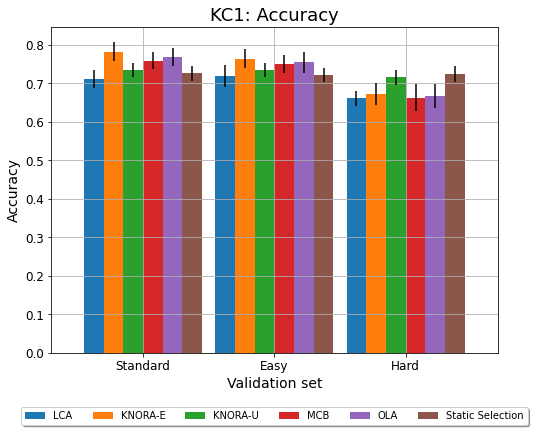

In [104]:
plot_by_metric(kc1_results_metric['accuracy'], 'KC1: Accuracy', 'Accuracy')

#### AUC

,LCA,KNORA-E,KNORA-U,MCB,OLA,Static Selection
Standard,0.710599,0.781807,0.734722,0.758250,0.766965,0.725469
Easy,0.719567,0.763587,0.734728,0.750700,0.754064,0.721829
Hard,0.660480,0.671361,0.715948,0.662382,0.666863,0.723494


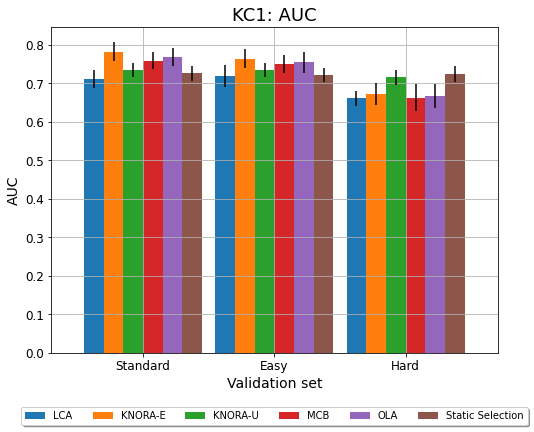

In [105]:
plot_by_metric(kc1_results_metric['auc'], 'KC1: AUC', 'AUC')

#### Medida F (f-measure)

,LCA,KNORA-E,KNORA-U,MCB,OLA,Static Selection
Standard,0.690888,0.774048,0.720977,0.749464,0.759897,0.711638
Easy,0.707982,0.758121,0.724232,0.746161,0.749724,0.707460
Hard,0.594838,0.620933,0.691138,0.611040,0.615502,0.702448


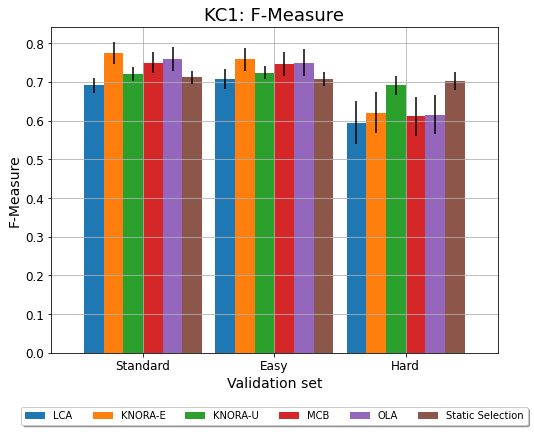

In [106]:
plot_by_metric(kc1_results_metric['f_measure'], 'KC1: F-Measure', 'F-Measure')

#### Média geométrica (g-mean)

,LCA,KNORA-E,KNORA-U,MCB,OLA,Static Selection
Standard,0.646661,0.749837,0.685368,0.725149,0.741435,0.677519
Easy,0.679192,0.744231,0.696595,0.735836,0.740873,0.673037
Hard,0.507140,0.544668,0.636583,0.534536,0.538463,0.653390


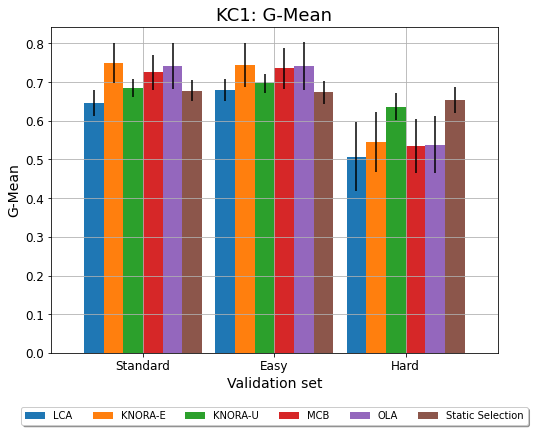

In [107]:
plot_by_metric(kc1_results_metric['g_mean'], 'KC1: G-Mean', 'G-Mean')

## Comparação entre as bases CM1 e KC1

#### Comparação por métrica
- Geração de um _Dataframe_ com os resultados dos algoritmos por configuração do subconjunto de validação:
    - Formato: média (desvio padrão)

In [28]:
def comparison_mean_std(result1, result2, databases=['CM1', 'KC1'], indexes=['LCA', 'KNORA-E', 'KNORA-U', 'MCB', 'OLA', 'Static Selection'], columns=['Standard', 'Easy', 'Hard']):
    mean1, std1 = separate_mean_std(result1)
    mean2, std2 = separate_mean_std(result2)
    
    header = pd.MultiIndex.from_product([databases, columns])
    
    df_mean1 = pd.DataFrame.from_dict(mean1)
    df_std1 = pd.DataFrame.from_dict(std1)
    
    df_mean2 = pd.DataFrame.from_dict(mean2)
    df_std2 = pd.DataFrame.from_dict(std2)
    
    df_mean = pd.concat([df_mean1, df_mean2], axis=1)
    df_std = pd.concat([df_std1, df_std2], axis=1)
    
    df_mean.columns = header
    df_std.columns = header
    
    df_mean.index=indexes
    df_std.index=indexes
    
    for database in databases:
        for column in columns:
            for index in indexes:
                df_mean.loc[index, (database, column)] = str(round(df_mean.loc[index, (database, column)], 2)) + ' (' + str(round(df_std.loc[index, (database, column)], 2)) + ')'
    
    df_mean.sort_index(inplace=True)
    
    return df_mean.style.apply(highlight_max)

def highlight_max(s):
    '''
    highlight the maximum in a Series.
    '''
    s_ = s.apply(lambda x: float(x[0:x.index(' (')]))
    is_max = s_ == s_.max()
    return ['font-weight: bold' if v else '' for v in is_max]

#### Acurácia

In [90]:
comparison_mean_std(cm1_results_metric2['accuracy'], kc1_results_metric2['accuracy'])

#### AUC

In [91]:
comparison_mean_std(cm1_results_metric2['auc'], kc1_results_metric2['auc'])

#### Média Geométrica (g-mean)

In [92]:
comparison_mean_std(cm1_results_metric2['g_mean'], kc1_results_metric2['g_mean'])

#### Medida F (f-measure)

In [93]:
comparison_mean_std(cm1_results_metric2['f_measure'], kc1_results_metric2['f_measure'])

#### Precisão

In [94]:
comparison_mean_std(cm1_results_metric2['precision'], kc1_results_metric2['precision'])

#### Cobertura

In [95]:
comparison_mean_std(cm1_results_metric2['recall'], kc1_results_metric2['recall'])